In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

In [ ]:
data = pd.read_csv('history_export.txt', sep="|", header = None)
data.columns = ["Time", "URL"]

In [ ]:
data['Time'] = pd.to_datetime(data['Time'])

In [ ]:
data.index = data['Time']
del data['Time']
domainList = [0]*len(data)

In [ ]:
headers = requests.utils.default_headers()
headers.update(
    {
        'User-Agent': 'Custom User Agent 1.0',
        'From': 'nsrivast@iitk.ac.in'  # Stick in your IITK email id
    }
)

In [ ]:

for idx in range(len(data)):
    print(idx)
    url = data.URL[idx]
    if(len(url)>5):
        try:
            r = requests.get(url, headers=headers)
        except:
            r = ''
            pass
        if(type(r)!=str):
            soup = BeautifulSoup(r.text, 'lxml')
            if(len(soup('title'))>0):
                if(soup('title')[0].string is not None):
                    domainList[idx] = soup('title')[0].string.encode('utf-8').strip()
                else:
                    domainList[idx] = "Null"
            else:
                domainList[idx] = "Null"
        else:
            domainList[idx] = "Null"

In [ ]:
data.to_csv('chrome_history.csv')

In [ ]:
data = pd.read_csv('chrome_history.csv')
data.Time = pd.to_datetime(data.Time)
docs = data.Domain.unique()

In [ ]:
data.head()

,Time,URL,Domain
0,2017-02-08 09:55:00,http://www.moneycontrol.com/stocksmarketsindia/,"Indian Stock/Share Market Live - BSE Sensex, N..."
1,2017-02-08 09:55:00,http://www.moneycontrol.com/,"Stock/Share Market Investing - Live BSE/NSE, I..."
2,2017-02-08 09:54:00,http://www.ndtv.com/,"NDTV: Latest News, India News, Breaking News, ..."
3,2017-02-08 05:07:00,http://localhost:8888/notebooks/Untitled.ipynb...,Jupyter Notebook
4,2017-02-08 05:07:00,http://localhost:8888/tree#,Home


In [ ]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()


In [ ]:
doc_set = docs.tolist()

In [ ]:
texts = []

# loop through document list
for i in doc_set:
    try:
        i.encode()
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stemmed_tokens)
    except AttributeError:
        texts.append([])
        pass
    except UnicodeDecodeError:
        texts.append([])
        pass

In [ ]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word = dictionary, passes=20)

In [ ]:
ldamodel.print_topics(3)

[(0,
  u'0.013*"india" + 0.012*"ndtv" + 0.010*"movi" + 0.010*"s" + 0.010*"com" + 0.009*"heater" + 0.009*"room" + 0.008*"kanpur" + 0.007*"trump" + 0.007*"action"'),
 (1,
  u'0.015*"python" + 0.014*"news" + 0.014*"stack" + 0.014*"overflow" + 0.013*"game" + 0.013*"fund" + 0.013*"recip" + 0.010*"indian" + 0.009*"s" + 0.009*"blackrock"'),
 (2,
  u'0.014*"p" + 0.013*"recip" + 0.013*"youtub" + 0.012*"best" + 0.011*"kanpur" + 0.010*"game" + 0.009*"pasta" + 0.009*"25" + 0.008*"light" + 0.008*"cook"')]

In [ ]:
ldamodel.get_topic_terms(0,10)

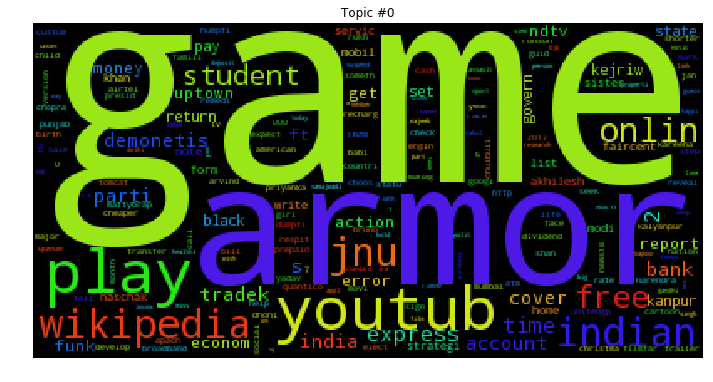

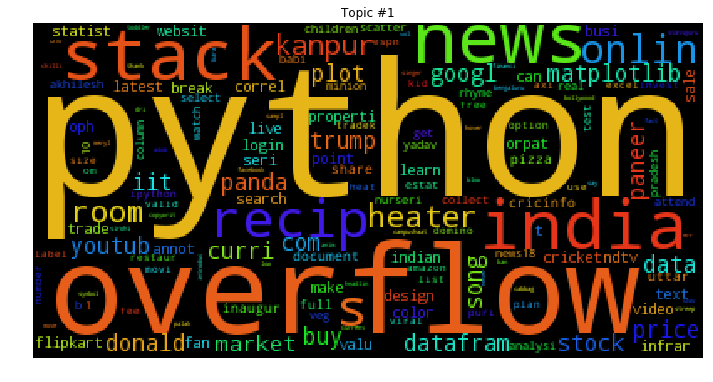

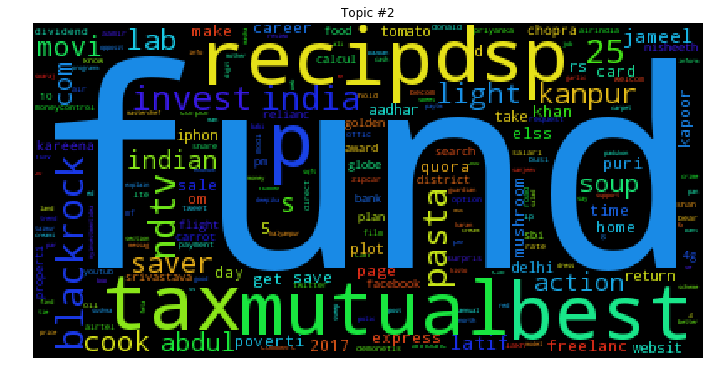

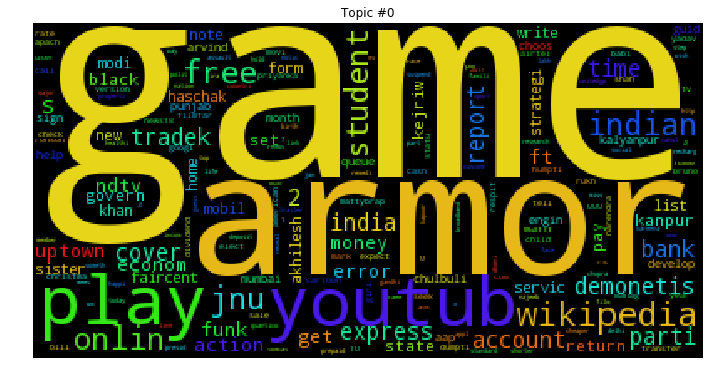

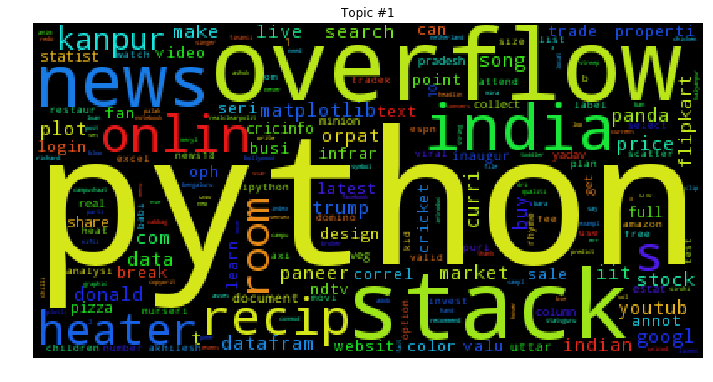

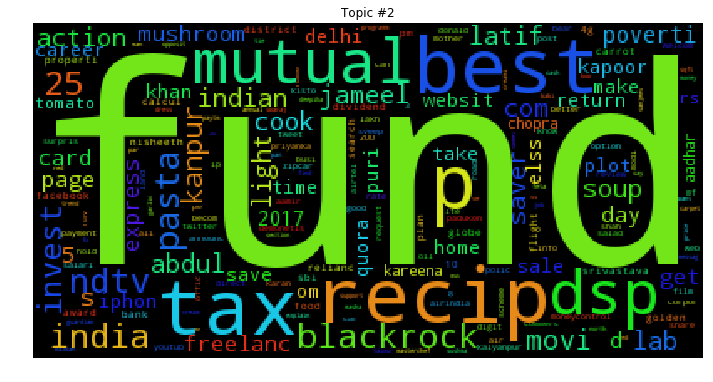

In [ ]:
from wordcloud import WordCloud, STOPWORDS
for t in range(ldamodel.num_topics):
    plt.figure(figsize=(12,8))
    plt.imshow(WordCloud().fit_words(ldamodel.show_topic(t, 200)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    #plt.savefig('topic #' + str(t) + '.png', bbox_inches='tight')
    plt.show()

In [ ]:
topic = [0]*len(data)
for idx in range(len(data)):
    test_idx = doc_set.index(data.Domain[idx])
    probs = ldamodel[dictionary.doc2bow(texts[test_idx])]
    prs = [item for sublist in probs for item in sublist]
    topicProbs = []
    for i in probs:
        topicProbs.append(i[1])
    topic[idx] = np.argmax(np.asarray(topicProbs))

In [ ]:
data['Topic'] = topic

In [ ]:
data.head()

,Time,URL,Domain,Topic
0,2017-02-08 09:55:00,http://www.moneycontrol.com/stocksmarketsindia/,"Indian Stock/Share Market Live - BSE Sensex, N...",1
1,2017-02-08 09:55:00,http://www.moneycontrol.com/,"Stock/Share Market Investing - Live BSE/NSE, I...",1
2,2017-02-08 09:54:00,http://www.ndtv.com/,"NDTV: Latest News, India News, Breaking News, ...",1
3,2017-02-08 05:07:00,http://localhost:8888/notebooks/Untitled.ipynb...,Jupyter Notebook,1
4,2017-02-08 05:07:00,http://localhost:8888/tree#,Home,2


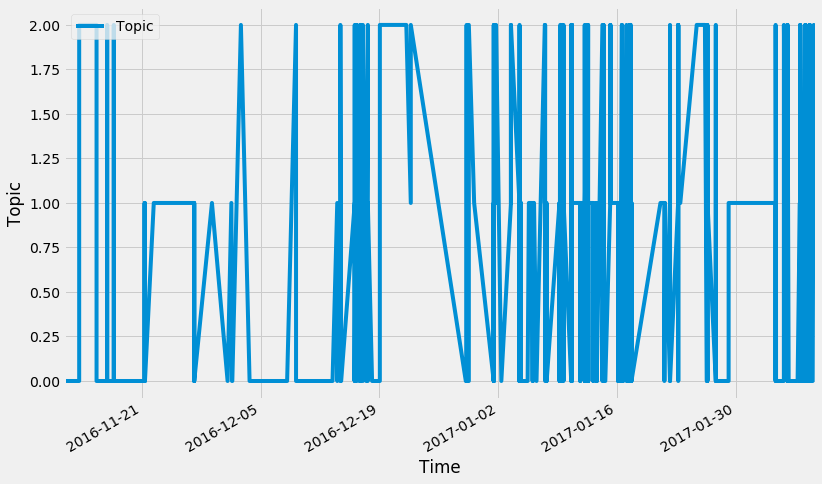

In [ ]:
sorted_data = data.sort_values('Time')
plt.style.use('fivethirtyeight')
sorted_data.plot(x='Time', y='Topic', figsize=(12,8))
plt.ylabel('Topic')
plt.show()

In [ ]:
cp_data = data

In [ ]:
cp_data.head()

In [ ]:
cp_data['Time'] = pd.to_datetime(cp_data['Time'])
cp_data.index = cp_data['Time']
del cp_data['Time']
cp_data.head()

,URL,Domain,Topic
Time,,,
2017-02-08 09:55:00,http://www.moneycontrol.com/stocksmarketsindia/,"Indian Stock/Share Market Live - BSE Sensex, N...",1
2017-02-08 09:55:00,http://www.moneycontrol.com/,"Stock/Share Market Investing - Live BSE/NSE, I...",1
2017-02-08 09:54:00,http://www.ndtv.com/,"NDTV: Latest News, India News, Breaking News, ...",1
2017-02-08 05:07:00,http://localhost:8888/notebooks/Untitled.ipynb...,Jupyter Notebook,1
2017-02-08 05:07:00,http://localhost:8888/tree#,Home,2


In [ ]:
occurrences = []
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
for day in weekdays:
    tlist = cp_data[cp_data.index.weekday_name == day].Topic.tolist()
    res = np.histogram(tlist,bins=[0,1,2,3])
    occurrences.append(list(res[0]))

In [ ]:
t0 = [0]*len(occurrences)
t1 = [0]*len(occurrences)
t2 = [0]*len(occurrences)

for d in range(len(occurrences)):
    t0[d] = occurrences[d][0]
    t1[d] = occurrences[d][1]
    t2[d] = occurrences[d][2]

cumt1 = [sum(x) for x in zip(t0, t1)]

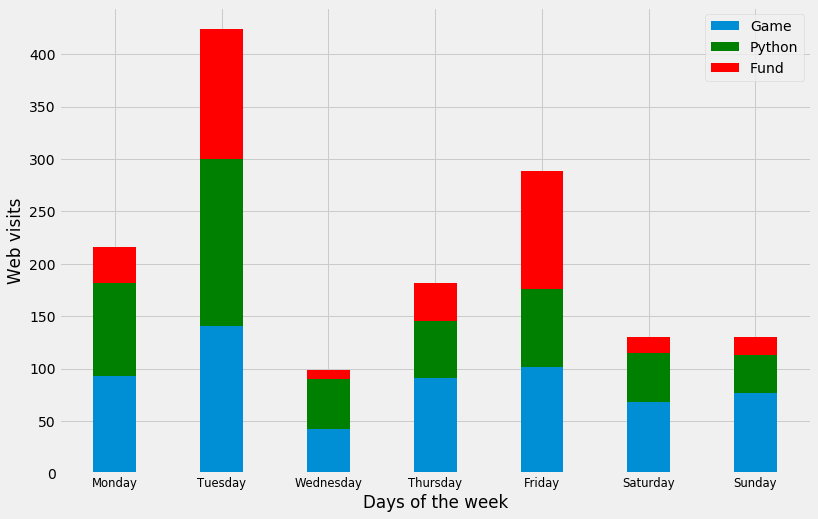

In [ ]:
plt.figure(figsize=(12,8))
p0 = plt.bar(range(7), t0, 0.4, label='Game')
p1 = plt.bar(range(7), t1, 0.4,bottom=t0, color='green', label='Python')
p2 = plt.bar(range(7), t2, 0.4, bottom=cumt1, color='red', label='Fund')
plt.xticks(range(7), weekdays, size='small')
plt.xlabel('Days of the week')
plt.ylabel('Web visits')
plt.legend()
plt.show()